In [30]:
import django, sys, os
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from pandas_ods_reader import read_ods
import pandas as pd
from scoping.models import *
import random
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import tensorflow as tf
#import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold

from sklearn.metrics import precision_score, recall_score, r2_score, f1_score


import matplotlib.pyplot as plt

django.db.connection.close()

In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('../literature_identification/jupyter-google-e4b72bf44320.json', scope)
gc = gspread.authorize(credentials)
spreadsheet_key = '1o18FIQTmGSWJ_m1ePAzrcVhFlfesESCb2bIEG7ibJAA'
wb = gc.open_by_key(spreadsheet_key)
ws = wb.worksheet("category_label_numbers")

In [3]:
table = ws.get_all_values()
category_map = pd.DataFrame(table[1:], columns=table[0])
category_map.head()

,Broad category,Specific category,Labelled documents,Proposed Aggregation 1,Proposed Aggregation 2,Proposed Aggregation 3
0,Physical systems,01 CO2 concentration,5,-,,
1,Physical systems,02 Air or land surface temperature changes,47,-,,
2,Physical systems,03 Extreme temperature,16,-,,
3,Physical systems,04 Radiation,1,-,,
4,Physical systems,05 Changes in precipitation,55,-,,


In [4]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

from alterations import postfix_data
df = postfix_data(df)

print(seen_df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

new_rel_index = physical_index.intersection(rel_index)

print(new_rel_index)

(2223, 242)
Int64Index([   3,    4,   12,   14,   17,   21,   24,   25,   28,   32,
            ...
            2204, 2205, 2211, 2212, 2214, 2215, 2216, 2219, 2220, 2222],
           dtype='int64', length=900)


In [5]:
impact_columns = [x for x in df.columns if re.match("^4 - ",x)]
for x in impact_columns:
    row = category_map.loc[category_map['Specific category']==x.split(' - ')[1]]
    if row.shape[0]==0:
        continue
    for i, aggscheme in enumerate(row[['Proposed Aggregation 1', 'Proposed Aggregation 2']].values[0]):
        if aggscheme not in ['-','']:
            nc = f'{17+i} - {aggscheme}'
            if nc not in df.columns:
                df[nc] = 0
            df.loc[df[x]==1,nc] = 1


In [6]:
specific_impacts_1 = [x for x in df.columns if "17 - " in x]
specific_impacts_1

['17 - Other rivers, lakes and soil',
 '17 - Water level',
 '17 - Evapotranspiration',
 '17 - Drought',
 '17 - Floods',
 '17 - Runoff',
 '17 - Snow',
 '17 - Permafrost',
 '17 - Sea ice',
 '17 - Glaciers',
 '17 - Distribution and range shifts (CMES)',
 '17 - Phenology (CMES)',
 '17 - Food/Agriculture',
 '17 - Corals',
 '17 - Physiology, metabolism, mortality and growth (CMES)',
 '17 - Community composition and interaction (CMES)',
 '17 - Ecosystem productivity and carbon cycle (CMES)',
 '17 - Distribution and range shifts (TES)',
 '17 - Phenology (TES)',
 '17 - Physiology, metabolism, mortality and growth (TES)',
 '17 - Community composition and interaction (TES)',
 '17 - Ecosystem productivity and carbon cycle (TES)',
 '17 - Wildfires',
 '17 - Livelihoods and wellbeing',
 '17 - Health',
 '17 - Displacement and migration']

In [7]:
specific_impacts_2 = [x for x in df.columns if "18 - " in x and df[x].sum() > 20 and "prediction" not in x]
specific_impacts_2

['18 - Terrestrial Water Cycle',
 '18 - Drought & Floods',
 '18 - Cryosphere',
 '18 - Coastal and marine Ecosystems',
 '18 - Food/Agriculture',
 '18 - Terrestrial ES',
 '18 - Wildfires',
 '18 - Livelihoods and wellbeing',
 '18 - Health',
 '18 - Displacement and migration']

In [8]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5, max_df=0.8, strip_accents='unicode', 
        max_features=50000,
        #tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2223, 19821)

In [9]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[specific_impacts_2])

print(y.shape)

test_index = random.sample(set(new_rel_index),200)
train_index = list(set(new_rel_index) - set(test_index))

clf = OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=1))

clf.fit(X[train_index], y[train_index])

(2223, 10)


OneVsRestClassifier(estimator=SVC(C=1, class_weight='balanced', kernel='linear',
                                  probability=True))

In [10]:
y[new_rel_index].sum(axis=0)

matrix([[141,  57,  68,  66,  50, 267,  28,  60, 118,  31]])

In [11]:
y_pred_prob = clf.predict_proba(X[test_index])
y_pred = clf.predict(X[test_index])

In [12]:
y_pred_prob[y_pred_prob>0.5].shape

(177,)

In [13]:
y.shape

(2223, 10)

In [14]:
y = np.matrix(df[specific_impacts_2])

weights = {}
for i,c in enumerate(specific_impacts_2):
    weights[i] =  round((1-y[new_rel_index,i].sum()/len(new_rel_index))*10)
    
weights

{0: 8.0,
 1: 9.0,
 2: 9.0,
 3: 9.0,
 4: 9.0,
 5: 7.0,
 6: 10.0,
 7: 9.0,
 8: 9.0,
 9: 10.0}

In [15]:
y[new_rel_index,5].sum()

267

In [16]:
df[(df.index.isin(new_rel_index)) & df.loc[:,specific_impacts_2].sum(axis=1)==0].shape

(1523, 280)

In [178]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[specific_impacts_2])
print(y.shape)




def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(200, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.verbose = 0
    model.epochs = 100
    model.custom_weights = {0:5,1:20,2:15,3:20,4:30,5:10, 6:15, 7:30, 8: 15, 9: 40}
    return model

# test_index = random.sample(set(new_rel_index),200)
# train_index = list(set(new_rel_index) - set(test_index))

model = get_model(X.shape[1],y.shape[1])


multimodels = [
#     {
#        'title': 'Keras', 
#        'model': get_model
#     },  
    {
        'title': 'One vs rest SVC balanced linear', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=1))
    },   
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_ar5, metrics, df = lu.cross_validate_models(X, y, multimodels, new_rel_index, n_splits=5, classes=specific_impacts_2, df = df, roundup=True)


(2223, 10)
1
2
3
4
5


[0.9793956043956044, 0.9297052154195012, 0.9885015734688937, 0.9794130067567568, 0.976460814178898]
auc
18 - Terrestrial Water Cycle
[0.9434165232358004, 0.9088219472834858, 0.9175145348837209, 0.9636488340192044, 0.9770114942528736]
auc
18 - Drought & Floods
[0.9917088899124827, 0.9923529411764707, 0.9919391985260249, 0.9947474747474747, 0.9740166005052328]
auc
18 - Cryosphere
[0.9735145094426532, 0.9836309523809523, 0.9882828282828282, 0.9823529411764705, 0.9839939024390244]
auc
18 - Coastal and marine Ecosystems
[0.9892650701899257, 0.9646337062432335, 0.9181286549707602, 0.9927325581395349, 0.9473684210526316]
auc
18 - Food/Agriculture
[0.9393721198156681, 0.9361221028829847, 0.9580965909090909, 0.9619636363636364, 0.9396923076923077]
auc
18 - Terrestrial ES
[0.9965714285714286, 0.998546511627907, 1.0, 0.9956395348837209, 1.0]
auc
18 - Wildfires
[0.8477011494252873, 0.8401658222017504, 0.8900891632373114, 0.96875, 0.8997979797979798]
auc
18 - Livelihoods and wellbeing
[0.9669677419

[Text(0, 0, 'auc\n18 - Terrestrial Water Cycle'),
 Text(0, 0, 'auc\n18 - Drought & Floods'),
 Text(0, 0, 'auc\n18 - Cryosphere'),
 Text(0, 0, 'auc\n18 - Coastal and marine Ecosystems'),
 Text(0, 0, 'auc\n18 - Food/Agriculture'),
 Text(0, 0, 'auc\n18 - Terrestrial ES'),
 Text(0, 0, 'auc\n18 - Wildfires'),
 Text(0, 0, 'auc\n18 - Livelihoods and wellbeing'),
 Text(0, 0, 'auc\n18 - Health'),
 Text(0, 0, 'auc\n18 - Displacement and migration')]

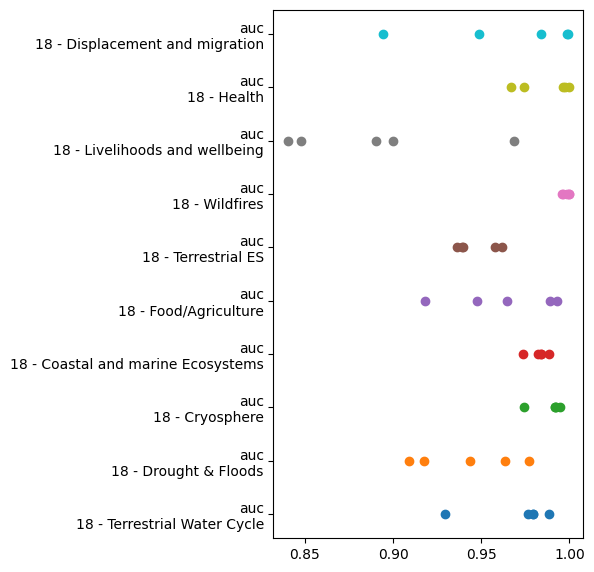

In [179]:
i = 0
fig, ax = plt.subplots(dpi=100,figsize=(4,7))
ticks = []
n = 0
for x in multimodels_ar5[n]:
    if "auc\n" in x:
        data = [y for y in multimodels_ar5[n][x] if y is not None]
        print(data)
        print(x)
        ax.scatter(data, [i]*len(data))
        i+=1
        ticks.append(x)
        
ax.set_yticks(range(i))
ax.set_yticklabels(ticks)

In [177]:
subset = df[
    (df.index.isin(new_rel_index)) &
    (df['content'].str.contains("female")) & 
    (df[c]<1)
]
for i, row in subset.head(0).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    print(row['title'], row['id'])
    print(row['content'])
    print(d.docusercat_set.filter(category__level__in=[4,6], category__project=178).values('category__name','category__level','user__username'))
    for col in df.columns:
        if "k_prediction" in col:
            print(col)
            print(row[col])

In [176]:
c = "18 - Livelihoods and wellbeing"
fp = df[
    (df[c]==0) & 
    (df[f"{c} - k_prediction"]>0.5)
].sort_values(f"{c} - k_prediction", ascending=False)
for i, row in fp.head(0).iterrows():
    d = Doc.objects.get(pk=row['id'])
    print()
    print(row['title'], row['id'])
    print(row['content'])
    print(d.docusercat_set.filter(category__level__in=[4,6], category__project=178).values('category__name','category__level','user__username'))
    for col in df.columns:
        if "k_prediction" in col:
            print(col)
            print(row[col])

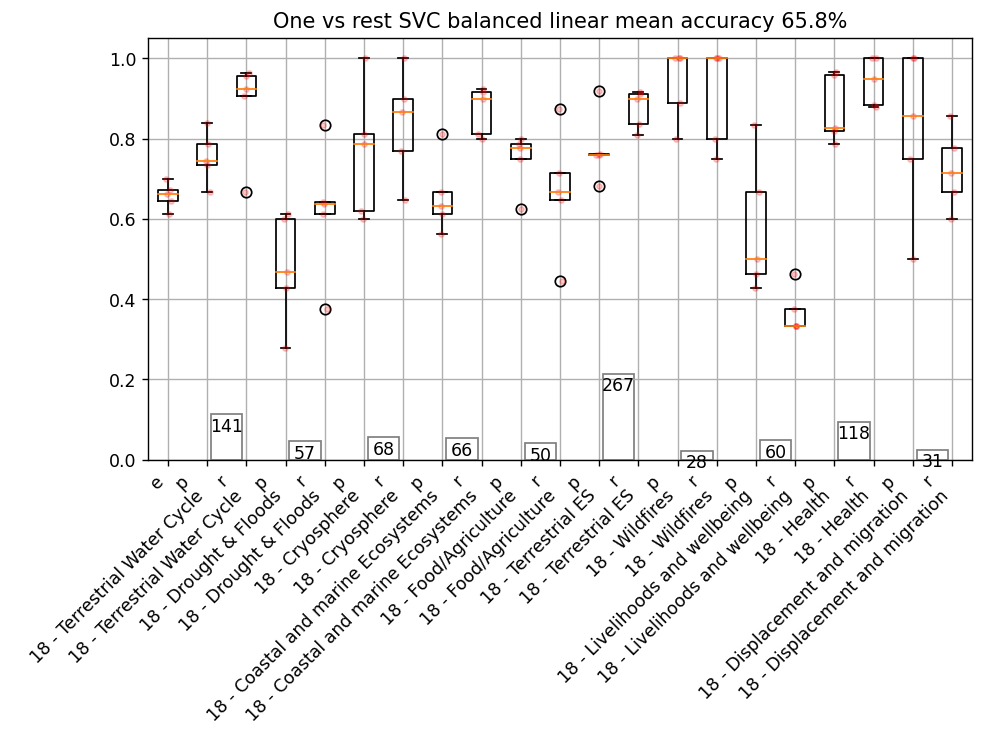

In [180]:


fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[0]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[new_rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

In [132]:
pred_cols = [x for x in df.columns if "k_pred" in x and "binary" not in x]
bin_pred_cols = [x for x in df.columns if "k_pred" in x and "binary" in x]
y_true = df.loc[new_rel_index, specific_impacts_2]
y_pred = df.loc[new_rel_index,pred_cols]
y_pred

,18 - Terrestrial Water Cycle - k_prediction,18 - Drought & Floods - k_prediction,18 - Cryosphere - k_prediction,18 - Coastal and marine Ecosystems - k_prediction,18 - Food/Agriculture - k_prediction,18 - Terrestrial ES - k_prediction,18 - Wildfires - k_prediction,18 - Livelihoods and wellbeing - k_prediction,18 - Health - k_prediction,18 - Displacement and migration - k_prediction
3,0.014793,0.015371,0.001299,0.000553,0.004606,0.829956,0.794301,0.009057,0.000747,0.006548
4,0.038583,0.009113,0.030493,0.034856,0.006702,0.514335,0.008331,0.021197,0.003074,0.006577
12,0.968244,0.029810,0.036350,0.000598,0.005072,0.169946,0.004132,0.010132,0.002284,0.004234
14,0.947192,0.003949,0.026245,0.000861,0.017597,0.013375,0.003091,0.038658,0.005928,0.007671
17,0.007062,0.017029,0.003435,0.001571,0.020681,0.034329,0.005628,0.310295,0.005870,0.990313
...,...,...,...,...,...,...,...,...,...,...
2215,0.004363,0.003823,0.996076,0.057014,0.003907,0.007746,0.003100,0.012953,0.004046,0.006783
2216,0.051156,0.025581,0.003563,0.002741,0.042402,0.964324,0.017035,0.016648,0.005163,0.003200
2219,0.007310,0.003316,0.003834,0.015670,0.004981,0.019880,0.005880,0.057383,0.999995,0.003677
2220,0.009902,0.005519,0.005252,0.959632,0.009775,0.233234,0.004061,0.020722,0.003579,0.007193


In [46]:
y_pred_binary = df.loc[new_rel_index, bin_pred_cols]

In [47]:
for i, c in enumerate(specific_impacts_2):
    f1 = f1_score(np.array(y_true)[:,i], np.array(y_pred_binary)[:,i])
    print(f1)

0.8122605363984673
0.48275862068965514
0.7741935483870968
0.5742574257425743
0.45714285714285713
0.813953488372093
0.8235294117647057
0.4
0.9130434782608696
0.7307692307692307


In [48]:
for i, c in enumerate(specific_impacts_2):
    f1 = f1_score(np.array(y_true)[:,i], np.round(np.array(y_pred)[:,i]))
    print(f1)

0.8195488721804511
0.5473684210526316
0.7761194029850745
0.7049180327868853
0.6590909090909091
0.813953488372093
0.8461538461538461
0.41860465116279066
0.9137931034482759
0.75


In [175]:
for i, c in enumerate(specific_impacts_2):
    y_pred_arr = np.array(y_pred)
    ai = np.expand_dims(np.argmax(y_pred_arr, axis=1), axis=1)
    maximums = np.maximum(y_pred_arr.max(1),0.51)
    np.put_along_axis(y_pred_arr, ai, maximums.reshape(ai.shape), axis=1)
    f1 = f1_score(np.array(y_true)[:,i], np.round(y_pred_arr[:,i]))
    print(f1)

0.8078175895765474
0.5426356589147286
0.7777777777777778
0.7333333333333334
0.7096774193548386
0.8175438596491228
0.9090909090909091
0.4242424242424242
0.9016393442622951
0.7931034482758621


In [173]:
y_pred_arr[9]
#idx = y_pred_arr.argmax(1,keep_dims=True)
#idx.shape

array([0.02024773, 0.02949293, 0.00848204, 0.00751975, 0.03404651,
       0.45039552, 0.00261443, 0.03480908, 0.00171526, 0.00920434])

In [156]:
maximums.reshape(900,1).shape

(900, 1)

In [169]:
a = y_pred_arr
ai = np.expand_dims(np.argmax(a, axis=1), axis=1)
maximums = np.maximum(y_pred_arr.max(1),0.51)

np.put_along_axis(a, ai, maximums.reshape(ai.shape), axis=1)
a[9]

array([0.02024773, 0.02949293, 0.00848204, 0.00751975, 0.03404651,
       0.51      , 0.00261443, 0.03480908, 0.00171526, 0.00920434])

In [161]:
maximums

array([0.82995574, 0.51433508, 0.96824427, 0.9471923 , 0.9903132 ,
       0.81129616, 0.97453306, 0.9882959 , 0.9669274 , 0.51      ,
       0.60697737, 0.51      , 0.51      , 0.93237929, 0.98937306,
       1.        , 0.9904322 , 0.95315192, 0.95987535, 0.98132404,
       0.9806117 , 0.51      , 0.99354008, 0.9925153 , 0.99694543,
       0.99999377, 0.9877716 , 0.87358401, 0.51      , 0.99035838,
       0.51      , 0.74173364, 0.51      , 0.81505088, 0.95587289,
       0.99999274, 0.99278041, 0.99518886, 0.87536108, 0.98903133,
       0.95010393, 0.99710905, 0.51      , 0.99374657, 0.99999996,
       0.96817987, 0.99999917, 0.96207427, 0.98379605, 0.8710825 ,
       0.97222917, 0.99328238, 0.85687024, 0.51      , 0.99269963,
       0.75413148, 0.51      , 0.99097512, 0.75417122, 0.57077444,
       0.99647557, 0.91176148, 0.97152917, 0.88992861, 0.96823814,
       0.71385317, 0.67849031, 0.95528329, 0.95756611, 0.78387988,
       0.91988091, 0.87870674, 0.51      , 0.51      , 0.97289

In [152]:
maximums.shape


(900,)

In [142]:
np.maximum(y_pred_arr.max(1),0.51)

array([0.82995574, 0.51433508, 0.96824427, 0.9471923 , 0.9903132 ,
       0.81129616, 0.97453306, 0.9882959 , 0.9669274 , 0.51      ,
       0.60697737, 0.51      , 0.51      , 0.93237929, 0.98937306,
       1.        , 0.9904322 , 0.95315192, 0.95987535, 0.98132404,
       0.9806117 , 0.51      , 0.99354008, 0.9925153 , 0.99694543,
       0.99999377, 0.9877716 , 0.87358401, 0.51      , 0.99035838,
       0.51      , 0.74173364, 0.51      , 0.81505088, 0.95587289,
       0.99999274, 0.99278041, 0.99518886, 0.87536108, 0.98903133,
       0.95010393, 0.99710905, 0.51      , 0.99374657, 0.99999996,
       0.96817987, 0.99999917, 0.96207427, 0.98379605, 0.8710825 ,
       0.97222917, 0.99328238, 0.85687024, 0.51      , 0.99269963,
       0.75413148, 0.51      , 0.99097512, 0.75417122, 0.57077444,
       0.99647557, 0.91176148, 0.97152917, 0.88992861, 0.96823814,
       0.71385317, 0.67849031, 0.95528329, 0.95756611, 0.78387988,
       0.91988091, 0.87870674, 0.51      , 0.51      , 0.97289

In [69]:
y_pred_arr[np.where(y_pred_arr==np.max(y_pred_arr,axis=1))] 

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


array([], shape=(0, 10), dtype=float64)

In [59]:
y_pred_arr[1].argmax()

5

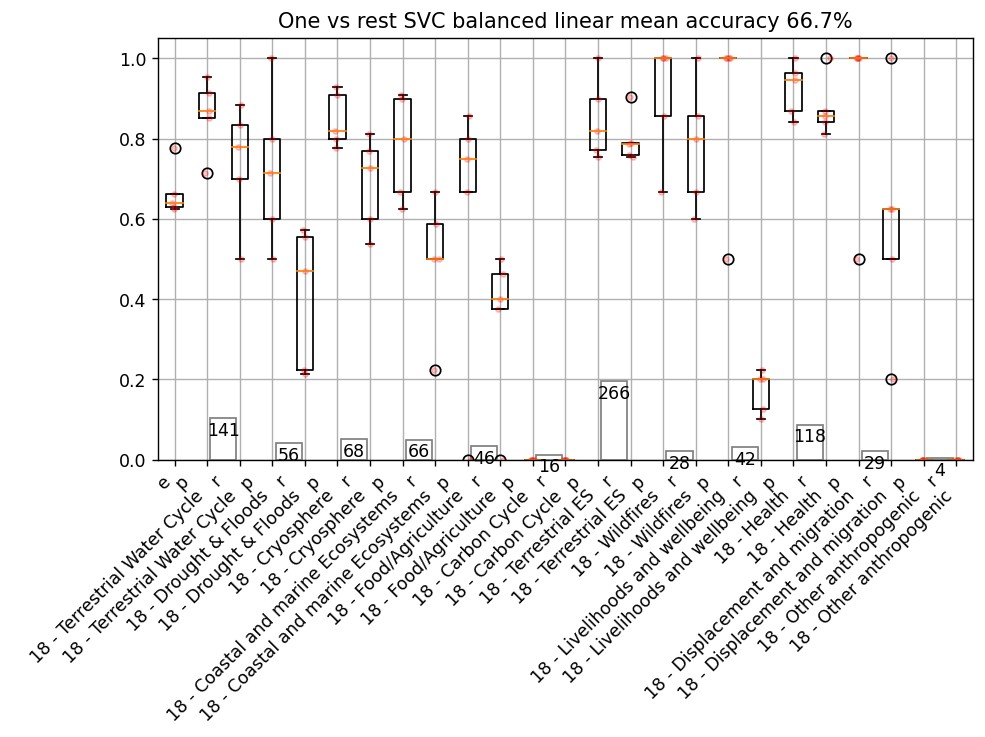

In [84]:


fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[1]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[new_rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

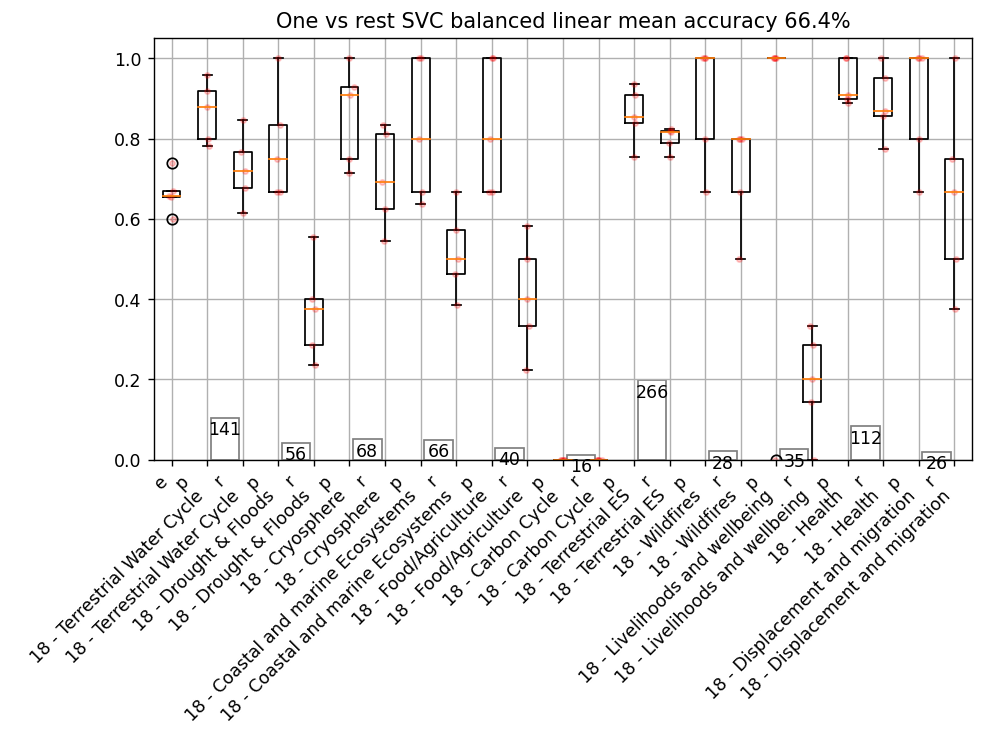

In [14]:


fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[0]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[new_rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

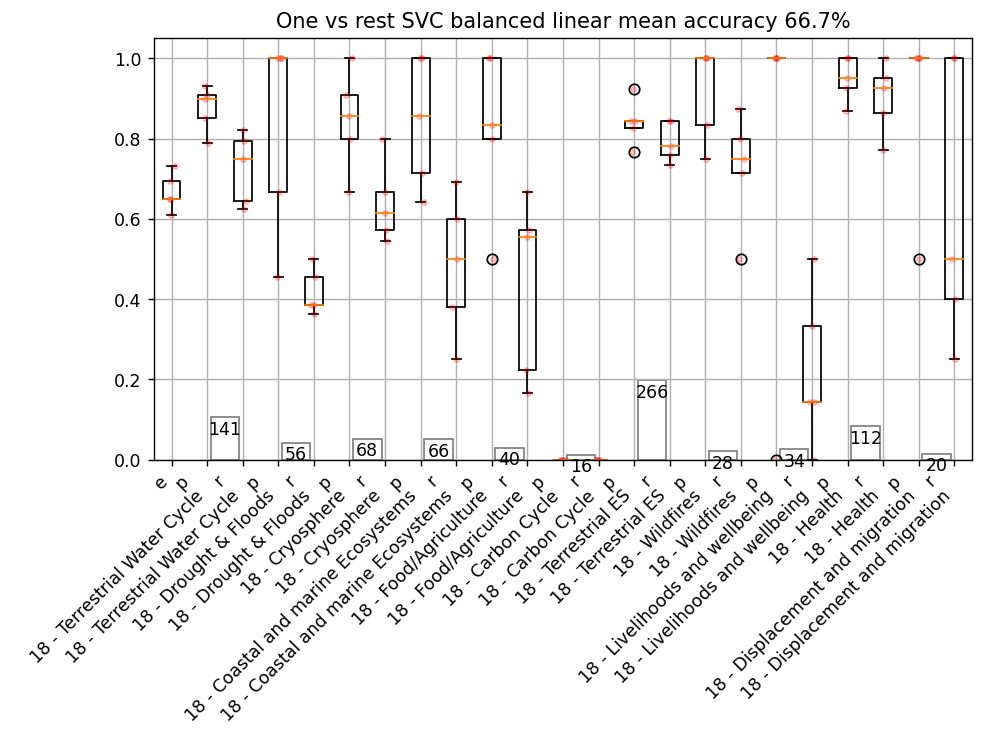

In [160]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[0]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[new_rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

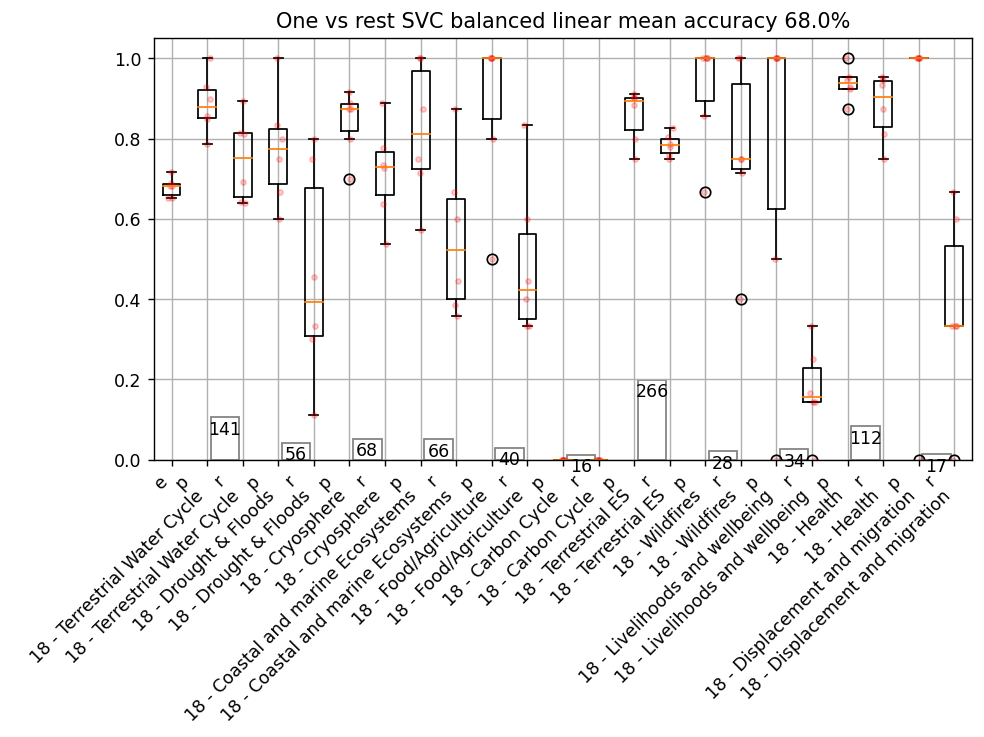

In [89]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[1]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[new_rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

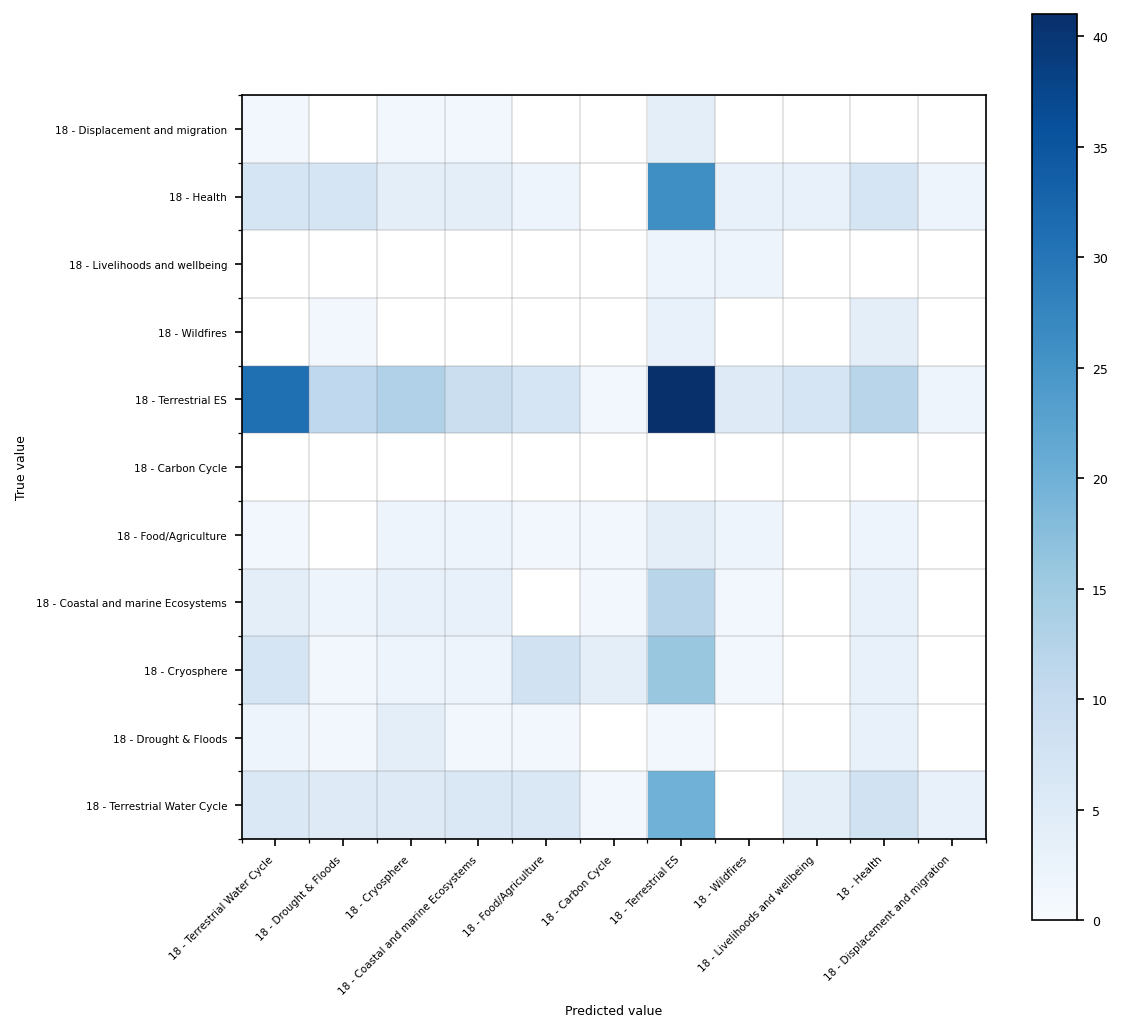

In [141]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

all_classes = specific_impacts_2
cols = [f"{c} - k_prediction_binary" for c in all_classes]
y_pred = np.array(list(df.loc[list(new_rel_index),cols].values))

   
y_true = y[physical_index]

confusion_matrix = np.zeros(shape=(len(cols),len(cols)),dtype=float).T

for j, c in enumerate(all_classes):
    for k, c in enumerate(all_classes):
        n = 0
        for i in range(len(new_rel_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n


def plot_confusion_matrix(cm, norm=None, broad_cats = [], ls=False):
    cm = np.copy(cm)
    if norm is not None:
        cm = cm/cm.sum(axis=norm,keepdims=True)
    cm[cm == 0] = np.nan

    mat = ax.imshow(cm, cmap="Blues",vmin=0,origin="lower")
    ax.set_xticks(np.arange(-.5, cm.shape[0], 1), minor=True);
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True);

    ax.grid(which="minor",color='grey', linestyle='-', linewidth=0.2)

    if ls:
        for j, c in enumerate(all_classes):
            for k, c in enumerate(all_classes):
                n  = cm[j,k]
                if n > 0.5:
                    color="#d9d9d9"
                else:
                    color="#525252"
                ax.text(j,k, f"{cm[j,k]:.0%}",ha="center",color=color)

    ax.set_xticks(list(range(len(all_classes))))
    ax.set_xticklabels([x.replace("4 - ","") for x in all_classes],rotation=45,ha="right",fontsize=5)

    ax.set_yticks(list(range(len(all_classes))))
    ax.set_yticklabels([x.replace("4 - ","") for x in all_classes],ha="right",fontsize=5)
    ax.set_ylabel("True value", fontsize=6)
    ax.set_xlabel("Predicted value", fontsize=6)


    cbar = fig.colorbar(mat, ax=ax)
    cbar.ax.tick_params(labelsize=6)
    
    if norm ==1:
        cbar.set_label("% of True values")
    
    for bc in broad_cats:
        rect = patches.Rectangle((bc['start']-0.5,bc['start']-0.5),bc['size'],bc['size'],fill=False)
        ax.add_patch(rect)
    
plot_confusion_matrix(confusion_matrix)

#plt.savefig(f'../plots/prediction_models/confusion_all_classes.pdf',bbox_inches="tight")


In [144]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = df["18 - Displacement and migration"]
print(y.shape)

single_models = [
#     {
#        'title': 'One vs rest SVC balanced rbf', 
#        'model': OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight="balanced"))
#     },  
    {
        'title': 'One vs rest SVC balanced linear', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=1))
    },   
    {
        'title': 'One vs rest SVC balanced linear', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=10))
    },   
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
dis_migrat, df = lu.cross_validate_models(X, y, single_models, new_rel_index, n_splits=3, df = df)


(2312,)
1
2
3


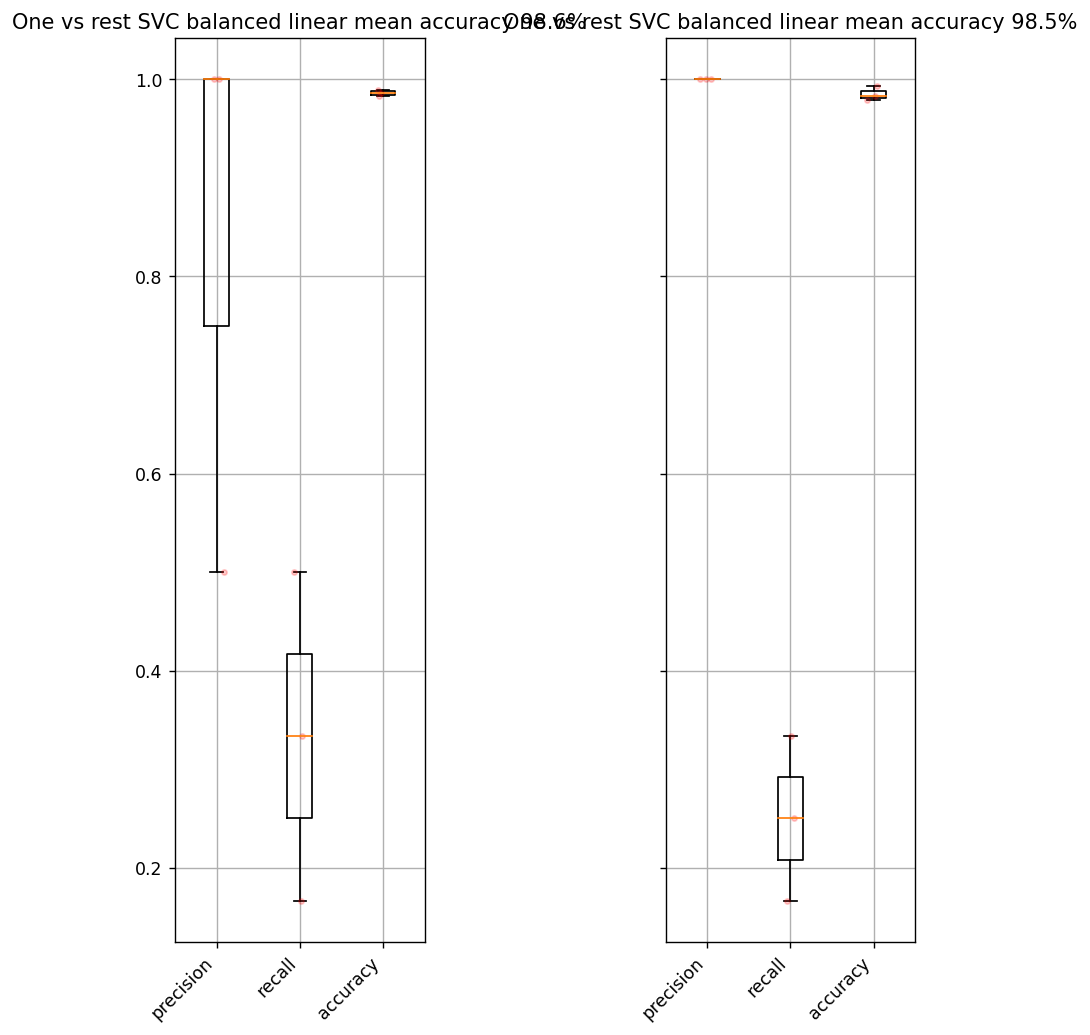

In [147]:
from importlib import reload  
import scoping.utils.learning_utils as lu
reload(scoping.utils.learning_utils)

fig, axs = plt.subplots(1, len(dis_migrat),dpi=125,figsize=(8,8),sharey=True)              
lu.plot_model_output(dis_migrat,  ['p','r','e'], fig, axs)
for ax in axs:
    ax.set_xticklabels(["precision","recall","accuracy"])
#fig.tight_layout()
#plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
plt.show()